# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке.

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета
- **Fare**: стоимость проезда пассажира
- **Cabin**: номер каюты
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import math

Установите количество пропущенных значений поля <code>age</code>:

In [388]:
data = pd.read_csv('titanic_train.csv')
S = 0
arr = data['age']
for elem in arr:
    if not elem > 0:
        S += 1
S

199

Определите долю выживших

In [389]:
arr = data['survived']
tot = 0
s = 0
for elem in arr:
    tot += 1
    if elem == 1:
        s += 1
s/tot
data

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,A. 2. 39186,8.0500,NaN,S,NaN
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S,"Vancouver, BC"
979,3,0,"Barton, Mr. David John",male,22.0,0,0,324669,8.0500,NaN,S,"England New York, NY"


Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [390]:
def isNaN(num):
    return num != num

data = pd.read_csv('titanic_train.csv').drop('ticket', axis=1)
count = 0
tot = len(data[data.columns[0]])
cols = data.drop('survived', axis=1).columns
for col in cols:
    for elem in data[col]:
        if isNaN(elem):
            count += 1
    if count/tot > 1/3:
        data = data.drop(col,axis=1)
    count = 0

Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>.

In [392]:
N = data.index[len(data.index)-1]+1
#data.insert(len(data.columns),'fam_size',[data['sibsp'][i] + data['parch'][i] for i in range(N)])
#data = data.drop(['sibsp','parch'],axis=1)

Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [309]:
import numpy as np
np.mean(data['fam_size'])

0.8664627930682977

На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [310]:
tot = 0
s = 0
for i in range(N):
    if data['sex'][i] == 'female' and data['pclass'][i] == 1:
        tot += 1
        if data['survived'][i] == 1:
            s += 1
s/tot

0.9711538461538461

Постройте гистограммы выжиших и невыживших по возрастам.

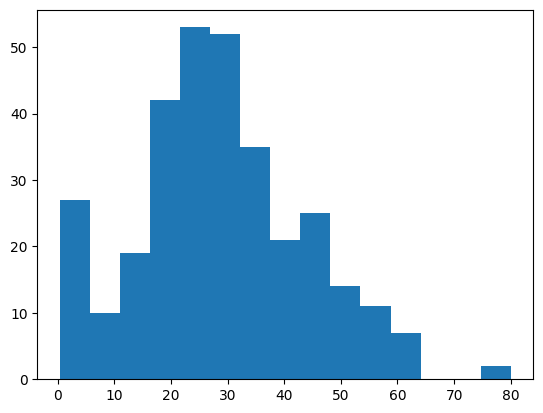

In [311]:
import matplotlib.pyplot as plt

arr = []
for i in range(N):
    if data['survived'][i] == 1:
        arr.append(data['age'][i])
plt.hist(arr,bins=15)
plt.show()

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [312]:
from sklearn.model_selection import train_test_split

dataN = data.drop(['name', 'sex', 'embarked'],axis=1)
dataN = dataN.dropna()
train, test = train_test_split(dataN, test_size=0.2, random_state=35, stratify = dataN['survived'])

logreg = LogisticRegression(random_state=35, max_iter=1000)
logreg.fit(train.drop('survived',axis=1), train['survived'])
ans = logreg.predict(test.drop('survived',axis=1))
f1_score(test['survived'], ans)

0.5178571428571429

## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [331]:
dataN = data.drop(['name', 'sex', 'embarked'],axis=1)
for col in dataN.columns:
    mean = np.mean(np.array(dataN[[col]].dropna()[col]))
    new = np.array(dataN[col])
    #print(new)
    for i in range(len(new)):
        if new[i] != new[i]:
            new[i] = mean
    dataN = dataN.drop(col, axis=1)
    dataN.insert(0, col, new)

train, test = train_test_split(dataN, test_size=0.2, random_state=35, stratify = dataN['survived'])

logreg = LogisticRegression(random_state=35, max_iter=1000)
logreg.fit(train.drop('survived',axis=1), train['survived'])
ans = logreg.predict(test.drop('survived',axis=1))
f1_score(test['survived'], ans)

0.4827586206896552

## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [332]:
dataN = data.drop(['sex', 'embarked'], axis=1)
hon = []
for elem in dataN['name']:
    words = elem.split()
    for i in range(len(words)):
        if words[i][-1] == '.' and words[i] != 'L.':
            hon.append(words[i][:len(words[i])-1:])
print(len(set(hon)))
for i in range(len(hon)):
    if hon[i] == 'Rev' or hon[i] == 'Col' or hon[i] == 'Dr' or hon[i] == 'Major' or hon[i] == 'Don' or hon[i] == 'Capt':
        hon[i] = 'Mr'
    if hon[i] == 'Dona' or hon[i] == 'Countess':
        hon[i] = 'Mrs'
    if hon[i] == 'Mlle' or hon[i] == 'Ms':
        hon[i] = 'Miss'
dataN.insert(0, 'honorific', hon)

14


Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [ ]:
# < ENTER YOUR CODE HERE >

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [333]:
men = 0
chil = 0
for i in range(len(dataN['age'])):
    if data['sex'][i] == 'male':
        men += 1
    if dataN['honorific'][i] == 'Master':
        chil += 1
chil/men

0.07232704402515723

Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [334]:
a = []
for i in range(len(dataN['honorific'])):
    if dataN['honorific'][i] == 'Master' and dataN['age'][i] == dataN['age'][i]:
        a.append(dataN['age'][i])
np.mean(a)

5.128205128205129

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [339]:
#dataN = dataN.drop(['name', 'honorific'],axis=1)
ages = dataN['age']
for i in range(len(ages)):
  if ages[i] != ages[i]:
    ages_cat = []
    for j in range(len(ages)):
      if ages[j]==ages[j] and dataN['honorific'][j]==dataN['honorific'][i]:
        ages_cat.append(ages[j])
    mean = np.mean(ages_cat)
    ages[i] = mean
dataN = dataN.drop(['age'],axis=1)
dataN.insert(0,'age',ages)

train, test = train_test_split(dataN, test_size=0.2, random_state=35, stratify = dataN['survived'])

logreg = LogisticRegression(random_state=35, max_iter=1000)
logreg.fit(train.drop('survived',axis=1), train['survived'])
ans = logreg.predict(test.drop('survived',axis=1))
f1_score(test['survived'], ans)

0.46551724137931033

# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [368]:
dataN = data
hon = []
for elem in dataN['name']:
    words = elem.split()
    for i in range(len(words)):
        if words[i][-1] == '.' and words[i] != 'L.':
            hon.append(words[i][:len(words[i])-1:])

for i in range(len(hon)):
    if hon[i] == 'Rev' or hon[i] == 'Col' or hon[i] == 'Dr' or hon[i] == 'Major' or hon[i] == 'Don' or hon[i] == 'Capt':
        hon[i] = 'Mr'
    if hon[i] == 'Dona' or hon[i] == 'Countess':
        hon[i] = 'Mrs'
    if hon[i] == 'Mlle' or hon[i] == 'Ms':
        hon[i] = 'Miss'
#dataN.insert(0, 'honorific', hon)

ages = dataN['age']
for i in range(len(ages)):
  if ages[i] != ages[i]:
    ages_cat = []
    for j in range(len(ages)):
      if ages[j]==ages[j] and dataN['honorific'][j]==dataN['honorific'][i]:
        ages_cat.append(ages[j])
    mean = np.mean(ages_cat)
    ages[i] = mean
dataN = dataN.drop(['age'],axis=1)
dataN.insert(0,'age',ages)

dataN = dataN.drop(['name','honorific'],axis=1)

dataN = pd.get_dummies(dataN, drop_first=True)

train, test = train_test_split(dataN, test_size=0.2, random_state=35, stratify = dataN['survived'])

logreg = LogisticRegression(random_state=35, max_iter=1000)
logreg.fit(train.drop('survived',axis=1), train['survived'])
ans = logreg.predict(test.drop('survived',axis=1))
f1_score(test['survived'], ans)

0.7101449275362319

In [417]:
dataN = data
test = pd.read_csv('titanic_reserved.csv')
N = test.index[len(test.index)-1]+1
test.insert(len(test.columns),'fam_size',[test['sibsp'][i] + test['parch'][i] for i in range(N)])
test = test.drop(['sibsp','parch'],axis=1)

hon1 = []
for elem in dataN['name']:
    words = elem.split()
    for i in range(len(words)):
        if words[i][-1] == '.' and words[i] != 'L.':
            hon1.append(words[i][:len(words[i])-1:])
hon2 = []
for elem in test['name']:
    words = elem.split()
    for i in range(len(words)):
        if words[i][-1] == '.' and words[i] != 'L.':
            hon2.append(words[i][:len(words[i])-1:])
#print(set(hon2))

for i in range(len(hon1)):
    if hon1[i] in ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']:
        hon1[i] = 'Mr'
    if hon1[i] in ['Dona', 'Countess']:
        hon1[i] = 'Mrs'
    if hon1[i] in ['Mlle', 'Ms']:
        hon1[i] = 'Miss'
#dataN.insert(0, 'honorific', hon1)
for i in range(len(hon2)):
    if hon2[i] == ['Dr', 'Major', 'Rev', 'Sir', 'Col', 'Jonkheer']:
        hon2[i] = 'Mr'
    if hon2[i] == ['Lady', 'Mme']:
        hon2[i] = 'Mrs'
    if hon2[i] in ['Mlle', 'Ms']:
        hon2[i] = 'Miss'
test.insert(0, 'honorific', hon2)


ages = dataN['age']
for i in range(len(ages)):
  if ages[i] != ages[i]:
    ages_cat = []
    for j in range(len(ages)):
      if ages[j]==ages[j] and dataN['honorific'][j]==dataN['honorific'][i]:
        ages_cat.append(ages[j])
    mean = np.mean(ages_cat)
    ages[i] = mean
dataN = dataN.drop(['age'],axis=1)
dataN.insert(0,'age',ages)

ages = test['age']
for i in range(len(ages)):
  if ages[i] != ages[i]:
    ages_cat = []
    for j in range(len(ages)):
      if ages[j]==ages[j] and test['honorific'][j]==test['honorific'][i]:
        ages_cat.append(ages[j])
    mean = np.mean(ages_cat)
    ages[i] = mean
test = test.drop(['age'],axis=1)
test.insert(0,'age',ages)

dataN = dataN.drop(['name','honorific'],axis=1)
test = test.drop(['name','honorific'],axis=1)

test = test.drop(['ticket','home.dest','cabin'],axis=1)

dataN = pd.get_dummies(dataN, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

logreg = LogisticRegression(random_state=35, max_iter=1000)
logreg.fit(dataN.drop('survived',axis=1), dataN['survived'])
from IPython.display import clear_output
clear_output()
logreg.predict(test)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,